### Import of requred libraries

In [1]:
!pip install multipledispatch

In [41]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
import torch.autograd as autograd

from src.icnn import DenseICNN
from src.tools import compute_l1_norm, energy_based_distance, ewma
from src import distributions
from src.distributions import DataLoaderWrapper

from src.experiments.state import State
from src.experiments.launcher import ExperimentLauncher
from src.experiments.experiments import RunnableItem, check_presence

### Creating state

In [57]:
LCH = ExperimentLauncher(create_level=True)

### Setting of configuration

In [58]:
class ConstantsSetup(RunnableItem):

    def internal_run(self, state):
        state.output = '8g' # or 8g, 25g, 49g, 100g, swiss
        state.gpu_device = 0
        state.batch_size = 1024
        state.device = 'cuda'

        if state.device == 'cuda':
            torch.cuda.empty_cache() 

LCH.launch(ConstantsSetup())

### Models setup

In [59]:
class ModelsSetup(RunnableItem):

    @check_presence('device')
    def internal_run(self, state):
        D = DenseICNN(
            2, rank=3, hidden_layer_sizes=[128, 128, 64],
            dropout=1e-5, strong_convexity=1e-6, device=state.device
        ).to(device=state.device)

        print(np.sum([np.prod(list(p.shape)) for p in D.parameters()]), 'parameters in Discriminative Network')

        # Manual weights init
        for p in D.parameters():
            p.data = torch.randn(p.shape, device=state.device, dtype=torch.float32) / 2.
            
        D_conj = DenseICNN(
            2, rank=3,
            hidden_layer_sizes=[128, 128, 64],
            dropout=1e-5, strong_convexity=1e-6, device = state.device
        ).to(device=state.device)

        for p in D_conj.parameters():
            p.data = torch.randn(p.shape, device=state.device, dtype=torch.float32) / 2.
        
        state.func = D
        state.gen = D_conj

LCH.launch(ModelsSetup())

27520 parameters in Discriminative Network


### Initializing data

In [60]:

class DistributionsInitializer(RunnableItem):

    @check_presence('output', 'device', 'batch_size')
    def internal_run(self, state):
        OUTPUT = state.output

        X_sampler = distributions.StandartNormalSampler(
            dim=2, requires_grad=True, device=state.device, random_seed=None, normalize=True)

        arg_dict = {'device':state.device, 'requires_grad':True, 'random_seed':None, 'normalize':True}

        if OUTPUT == '8g':
            Y_sampler = distributions.Mix8GaussiansSampler(**arg_dict)
        elif OUTPUT == '25g':
            Y_sampler = distributions.MixN2GaussiansSampler(n=5, **arg_dict)
        elif OUTPUT == '49g':
            Y_sampler = distributions.MixN2GaussiansSampler(n=7, **arg_dict)
        elif OUTPUT == '100g':
            Y_sampler = distributions.MixN2GaussiansSampler(n=10, **arg_dict)
        elif OUTPUT == 'swiss':
            Y_sampler = distributions.SwissRollSampler(**arg_dict)
        else:
            raise Exception('Unknown output distribution')

        state.source_dist = DataLoaderWrapper(X_sampler, state.batch_size)
        state.target_dist = DataLoaderWrapper(Y_sampler, state.batch_size)

LCH.launch(DistributionsInitializer())

### Helpful classes and functions

In [61]:
#TODO: locate these classes and functions in ../src

def finalize_ax(ax):
    ax.grid(b=True, which='both')
    ax.minorticks_on()

class LossCollector:

    def __init__(self, n_averaging):
        self.n_averaging = n_averaging
        self.collected = 0
        self.history = []
        self.current = 0.

    
    def add(self, value):
        if self.collected < self.n_averaging:
            if isinstance(value, torch.Tensor):
                value = value.item()
            self.current += value
            self.collected += 1

        if self.collected == self.n_averaging:
            self.history.append(self.current/self.n_averaging)
            self.reset_current()
    
    def reset_current(self):
        self.collected = 0
        self.current = 0.
    
    def reset(self):
        self.history = []
        self.reset_current()
    
    def get_history(self, inscribe_incomplete=False, incomplete_limit=1):
        history = self.history
        if inscribe_incomplete:
            assert(incomplete_limit >= 1)
            if self.collected >= incomplete_limit:
                history.append(self.current/self.collected)
        return history

### Creation of train loop

In [62]:
class DataloaderContinuator:

    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.cur_dataloader_iter = iter(self.dataloader)
    
    def __next__(self):
        try:
            batch = next(self.cur_dataloader_iter)
            return batch
        except StopIteration:
            self.cur_dataloader_iter = iter(self.dataloader)
            batch = next(self.cur_dataloader_iter)
            return batch


def compute_grad(model, input, output=None):
    if output is None:
        output = model(input)
    _grad = autograd.grad(
        outputs=output, 
        inputs=input,
        create_graph=True, 
        retain_graph=True,
        only_inputs=True,
        grad_outputs=torch.ones_like(output)
        )[0]
    return _grad

def relaxed_positive_weight_regularizer(model):
    regularizer = 0.
    for param in model.parameters():
        regularizer += param.data.clamp(max=0.).pow(2).sum()
    return regularizer

def forse_positive_weight(model):
    for param in model.parameters():
        param.data.clamp_(0.)

class W2MinMaxSolver(RunnableItem):

    def show_training(self, state, iteration):

        clear_output(wait=True)
        print("Iteration", iteration)
        
        fig, axes = plt.subplots(1, 3, figsize=(12, 3))
        axes[0].plot(
            range(0, state.energy_averaging_factor * len(state.QP_energy), state.energy_averaging_factor),
            np.log10(np.abs(ewma(state.QP_energy, span=1000)))
        )
        axes[0].set_title('Energy Q P')
        axes[0].set_xlabel('Iteration')
        axes[0].set_ylabel('log10(E)')

        max_loss_history = state.max_loss.get_history()
        min_loss_history = state.min_loss.get_history()
        axes[1].plot(
            range(0, state.max_loss.n_averaging * len(max_loss_history), state.max_loss.n_averaging),
            max_loss_history
        )
        axes[1].set_title('Max loss history')
        axes[1].set_xlabel('Iteration', fontsize=11)

        axes[2].plot(
            range(0, state.min_loss.n_averaging * len(min_loss_history), state.min_loss.n_averaging),
            min_loss_history
        )
        axes[2].set_title('Min loss history')
        axes[2].set_xlabel('Iterations')
        
        fig.tight_layout()
        plt.show()

        fig, axes = plt.subplots(1, 2, figsize=(8, 3))

        Y = state.source_dist.sampler.sample(state.energy_batchsize)
        X_from_Y = compute_grad(state.gen, Y).detach().cpu().numpy()
        X = state.target_dist.sampler.sample(state.energy_batchsize).detach().cpu().numpy()

        axes[0].scatter(X[:, 0], X[:, 1], edgecolors='black', s=4.)
        axes[0].set_title('Desired distrib')
        axes[1].scatter(X_from_Y[:, 0], X_from_Y[:, 1], edgecolors='black', s=4.)
        axes[1].set_title('Constructed distrib')
        plt.show()


    def store_energy(self, state):
        state.gen.eval(); state.func.eval()

        Y = state.source_dist.sampler.sample(state.energy_batchsize)
        X = state.target_dist.sampler.sample(state.energy_batchsize)
        X_from_Y = compute_grad(state.gen, Y).detach()
        with torch.no_grad():
            state.QP_energy.append(
                energy_based_distance(X, X_from_Y, device=state.device).item())
        
        state.gen.train(True); state.func.train(True)
    
    def preprocessing(self, state):

        state.total_iterations = 3000
        state.g_iterations = 20
        state.f_iterations = 1
        state.lr = 1e-4
        state.energy_averaging_factor = 20
        state.loss_averaging_factor = 20
        state.energy_batchsize = 1024
        state.show_factor = 40
        state.upd_loss_stat_factor = 200

        state.QP_energy = []
        max_loss_n_av = (state.loss_averaging_factor // state.f_iterations) * state.f_iterations
        state.max_loss = LossCollector(max_loss_n_av)
        min_loss_n_av = (state.loss_averaging_factor // state.g_iterations) * state.g_iterations
        state.min_loss = LossCollector(min_loss_n_av)

        state.func_optim = torch.optim.Adam(state.func.parameters(), lr=state.lr, betas=(0.8, 0.99))
        state.gen_optim = torch.optim.Adam(state.gen.parameters(), lr=state.lr, betas=(0.4, 0.4))
        state.positive_w_reg_lambda = 1.0


    def internal_run(self, state):

        Ti = state.total_iterations
        Gi = state.g_iterations
        Fi = state.f_iterations
        Sdist = DataloaderContinuator(state.source_dist)
        Tdist = DataloaderContinuator(state.target_dist)
        gen = state.gen
        func = state.func
        gen_optim = state.gen_optim
        func_optim = state.func_optim
        positive_w_reg_lambda = state.positive_w_reg_lambda
        gen_optim.zero_grad(); func_optim.zero_grad()
        gen.train(True); func.train(True)

        for t in range(Ti):
            if t % state.upd_loss_stat_factor == 0:
                state.min_loss.reset()
                state.max_loss.reset()

            # inner cycle 
            for n_g_it in range(Gi):
                func.eval()
                s_batch = next(Sdist)
                # print(s_batch.device)
                b_size = s_batch.size(0)
                g_grad = compute_grad(gen, s_batch)
                #TODO: may be set parameters of f to have requires_grad = False
                # adjusted J ( \theta_f, \theta_g) loss (without -f(t_batch) term)
                loss = (func(g_grad).squeeze() - (s_batch * g_grad).sum(-1)).mean()
                # R(\theta_g) regularizer
                loss += positive_w_reg_lambda * relaxed_positive_weight_regularizer(gen)
                state.min_loss.add(loss.item())
                loss.backward()
                gen_optim.step()
                gen_optim.zero_grad(); func_optim.zero_grad()
                func.train(True)

            # in the article Fi equals to 1
            for n_f_it in range(Fi):
                gen.eval()
                s_batch = next(Sdist)
                t_batch = next(Tdist)
                b_size = s_batch.size(0)
                g_grad = compute_grad(gen, s_batch).detach()
                # J(\theta_F, \theta_g) loss
                loss = - (func(g_grad).squeeze() - \
                        (s_batch * g_grad).view(b_size, -1).sum(-1) -\
                        func(t_batch).squeeze()).mean()
                state.max_loss.add(loss.item())
                loss.backward()
                func_optim.step()
                gen_optim.zero_grad(); func_optim.zero_grad()
                gen.train(True)
                forse_positive_weight(func)
            
            if t % state.energy_averaging_factor == 0:
                self.store_energy(state)
            
            if t % state.show_factor == 0:
                self.show_training(state, t)

### Run train loop

Iteration 2960


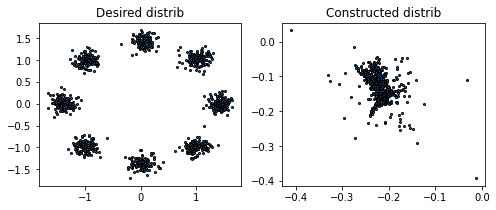

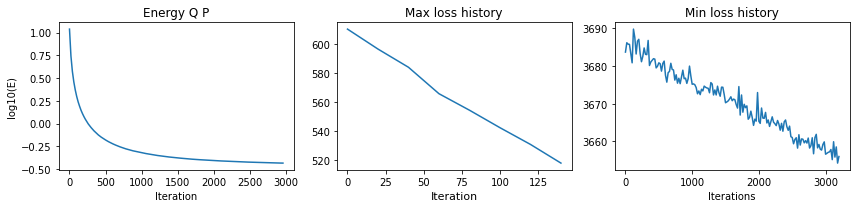

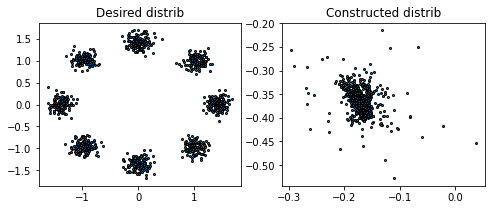

In [63]:
with LCH.localize():
    LCH.launch(W2MinMaxSolver())

In [ ]:
LCH.state.detach_level()

In [ ]:
LCH.state.level_states

[&lt;src.experiments.state.LevelState at 0x947c83e188&gt;]